In [3]:
import argparse
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
from copy import deepcopy
from torch.nn import CrossEntropyLoss
from easydict import EasyDict as edict
from torch.linalg import matrix_rank, svdvals
from collections import defaultdict
parser = argparse.ArgumentParser(description='Colored MNIST')
parser.add_argument('--hidden_dim', type=int, default=256)
parser.add_argument('--l2_regularizer_weight', type=float,default=0.001)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--n_restarts', type=int, default=10)
parser.add_argument('--penalty_anneal_iters', type=int, default=100)
parser.add_argument('--penalty_weight', type=float, default=10000.0)
parser.add_argument('--steps', type=int, default=501)
parser.add_argument('--grayscale_model', action='store_true')
#flags = parser.parse_args()

flags = edict()
flags.hidden_dim = 256
flags.l2_regularizer_weight = 0.001
flags.lr = 0.001
flags.n_restarts = 1
flags.penalty_anneal_iters = 0
flags.penalty_weight = 0
flags.steps = 1001
flags.grayscale_model = False

# Define loss function helpers

def mean_nll(logits, y):
    return nn.functional.binary_cross_entropy_with_logits(logits, y)

def mean_accuracy(logits, y):
    preds = (logits > 0.).float()
    return ((preds - y).abs() < 1e-2).float().mean()

def mean_accuracy2(logits, y):
    _, predicted_classes = torch.max(logits, 1)
    correct = (predicted_classes == y).sum()
    accuracy = correct / y.size(0)
    return accuracy

def penalty(logits, y):
    scale = torch.tensor(1.).cuda().requires_grad_()
    loss = mean_nll(logits * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)

# Train loop

def pretty_print(*values):
    col_width = 13
    def format_val(v):
        if not isinstance(v, str):
            v = np.array2string(v, precision=5, floatmode='fixed')
        return v.ljust(col_width)
    str_values = [format_val(v) for v in values]
    print("   ".join(str_values))

print('Flags:')
for k,v in sorted(vars(flags).items()):
    print("\t{}: {}".format(k, v))




# Load MNIST, make train/val splits, and shuffle train set examples

mnist = datasets.MNIST('../datasets', train=True, download=True)
mnist_train = (mnist.data[:50000], mnist.targets[:50000])
mnist_val = (mnist.data[50000:], mnist.targets[50000:])

rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

      # Build environments

def make_environment(images, labels, e):
    def torch_bernoulli(p, size):
        return (torch.rand(size) < p).float()
    def torch_xor(a, b):
        return (a-b).abs() # Assumes both inputs are either 0 or 1
    # 2x subsample for computational convenience
    images = images.reshape((-1, 28, 28))[:, ::2, ::2]
    orig_labels = deepcopy(labels)
    # Assign a binary label based on the digit; flip label with probability 0.25
    labels = (labels < 5).float()
    #labels = torch_xor(labels, torch_bernoulli(0.25, len(labels)))
    # Assign a color based on the label; flip the color with probability e
    colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
    # Apply the color to the image by zeroing out the other color channel
    images = torch.stack([images, images], dim=1)
    images[torch.tensor(range(len(images))), (1-colors).long(), :, :] *= 0
    return {
      'images': (images.float() / 255.).cuda(),
      'labels': labels[:, None].cuda(),
      'orig_labels': orig_labels.cuda()
    }

envs = [
make_environment(mnist_train[0][::2], mnist_train[1][::2], 0.5),
make_environment(mnist_train[0][1::2], mnist_train[1][1::2], 0.5),
make_environment(mnist_val[0], mnist_val[1], 0.5)
]

    # Define and instantiate the model

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        if flags.grayscale_model:
            self.lin1 = nn.Linear(14 * 14, flags.hidden_dim)
        else:
            self.lin1 = nn.Linear(2 * 14 * 14, flags.hidden_dim)
        self.lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
        self.head1 = nn.Linear(flags.hidden_dim, 1)
        self.head2 = nn.Linear(flags.hidden_dim, 10)
        self.relu = nn.ReLU(True)
        for lin in [self.lin1, self.lin2, self.head1, self.head2]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
     #self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True))
    def forward(self, input):
        if flags.grayscale_model:
            out = input.view(input.shape[0], 2, 14 * 14).sum(dim=1)
        else:
            out = input.view(input.shape[0], 2 * 14 * 14)

        r1 = self.lin1(out)
        r1_r = self.relu(r1)
        r2 = self.lin2(r1_r)
        r2_r = self.relu(r2)
        out1 = self.head1(r2_r)
        out2 = self.head2(r2_r)
        return out1, out2, {'fc1': r1,'fc2': r2, 'fc1_r': r1_r, 'fc2_r': r2_r}


   

Flags:
	grayscale_model: False
	hidden_dim: 256
	l2_regularizer_weight: 0.001
	lr: 0.001
	n_restarts: 1
	penalty_anneal_iters: 0
	penalty_weight: 0
	steps: 1001


In [53]:
%%time
flags.steps = 1001

losses = {'train': [], 'test': [], 'orig_train': [], 'orig_test': []}
accuracies = {'train': [], 'test': [], 'orig_train': [], 'orig_test': []}
ranks = {'train': defaultdict(list), 'test': defaultdict(list)}
vals = {'train': defaultdict(list), 'test': defaultdict(list)}
# Start of TRAINING

train_spur = False
train_orig = True


mlp = MLP().cuda()
optimizer = optim.Adam(mlp.parameters(), lr=flags.lr)

pretty_print('step', 'train nll', 'train acc', 'test acc','orig nll', 'orig acc', 'test orig acc')

cross_entropy = CrossEntropyLoss()

print(f"Spur: {train_spur} - Orig: {train_orig}")
for step in range(flags.steps):
    for env in envs:
        logits1, logits2, reps = mlp(env['images'])
        env['nll'] = mean_nll(logits1, env['labels'])
        env['acc'] = mean_accuracy(logits1, env['labels'])
        for k, v in reps.items():
            with torch.no_grad():
                env[f'rank_{k}'] = matrix_rank(reps[k].clone().cpu()).cpu()
                env[f'sv_{k}']= svdvals(reps[k].cpu())[:10]
        env['nll2'] = cross_entropy(logits2, env['orig_labels'])
        env['acc2'] = mean_accuracy2(logits2, env['orig_labels'])


    train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
    test_nll = envs[2]['nll']
    train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
    train_orig_nll = torch.stack([envs[0]['nll2'], envs[1]['nll2']]).mean()
    test_orig_nll = envs[2]['nll2']
    train_orig_acc = torch.stack([envs[0]['acc2'], envs[1]['acc2']]).mean()

    weight_norm = torch.tensor(0.).cuda()
    for w in mlp.parameters():
        weight_norm += w.norm().pow(2)

    loss = 0
    if train_spur:
        loss = train_nll.clone()
    loss += flags.l2_regularizer_weight * weight_norm

    #loss += penalty_weight * train_penalty
    if train_orig:
        loss += train_orig_nll.clone()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_acc = envs[2]['acc']
    test_orig_acc = envs[2]['acc2']
    accuracies['train'].append(train_acc.cpu().item())
    accuracies['test'].append(test_acc.cpu().item())
    accuracies['orig_train'].append(train_orig_acc.cpu().item())
    accuracies['orig_test'].append(test_orig_acc.cpu().item())
    losses['train'].append(train_nll.detach().cpu().item())
    losses['test'].append(test_nll.detach().cpu().item())
    losses['orig_train'].append(train_orig_nll.detach().cpu().item())
    losses['orig_test'].append(test_orig_nll.detach().cpu().item())

    for k, v in envs[0].items():
        if "rank" in k:
            ranks['train'][k.replace("rank_","")].append(envs[0][k])
            ranks['test'][k.replace("rank_","")].append(envs[2][k])
            
        if "sv" in k:
            vals['train'][k.replace("sv_","")].append(envs[0][k])
            vals['test'][k.replace("sv_","")].append(envs[2][k])

    if step % 100 == 0:
        pretty_print(
          np.int32(step),
          train_nll.detach().cpu().numpy(),
          train_acc.detach().cpu().numpy(),
          test_acc.detach().cpu().numpy(),
          train_orig_nll.detach().cpu().numpy(),
          train_orig_acc.detach().cpu().numpy(),
          test_orig_acc.detach().cpu().numpy()
        )

step            train nll       train acc       test acc        orig nll        orig acc        test orig acc
Spur: False - Orig: True
0               0.69928         0.49540         0.50330         2.31511         0.10862         0.11240      
100             0.69514         0.48922         0.49440         0.25504         0.92994         0.93190      
200             0.69189         0.52228         0.52710         0.16267         0.95822         0.95340      
300             0.69311         0.43052         0.42940         0.12609         0.96978         0.96070      
400             0.69316         0.43648         0.42830         0.11099         0.97468         0.96490      
500             0.69315         0.56696         0.55250         0.10406         0.97728         0.96670      
600             0.69315         0.54524         0.54340         0.10046         0.97850         0.96820      
700             0.69315         0.51076         0.50580         0.09836         0.97920        

In [55]:
new_data = dict()
new_vals = {'train': defaultdict(dict) , 'test': defaultdict(dict)}

for k in ['fc1', 'fc2']:
    #new_data[f"diff_{k}"] = [x - y for x,y in zip(train_ranks[k],train_ranks[k + "_r"])]
    new_data[f"split_diff_{k}"] = [x - y for x,y in zip(ranks['test'][k + "_r"],ranks['train'][k+"_r"])]


for split in ['train', 'test']:
    for k, v in vals[split].items():
        if k in ['fc1_r','fc2_r']:
            new_vals[split][k]['max'] = []
            new_vals[split][k]['min'] = []
            new_vals[split][k]['mean'] = []
            for v1 in v:
                new_vals[split][k]['max'].append(max(v1))
                new_vals[split][k]['min'].append(min(v1))
                new_vals[split][k]['mean'].append(v1.mean())

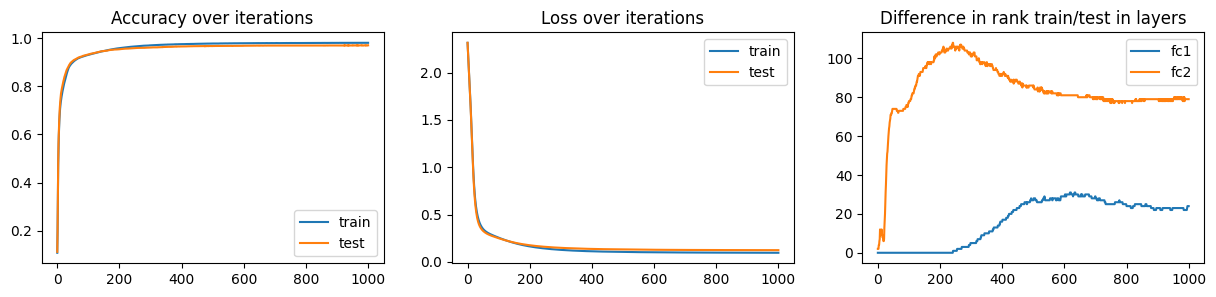

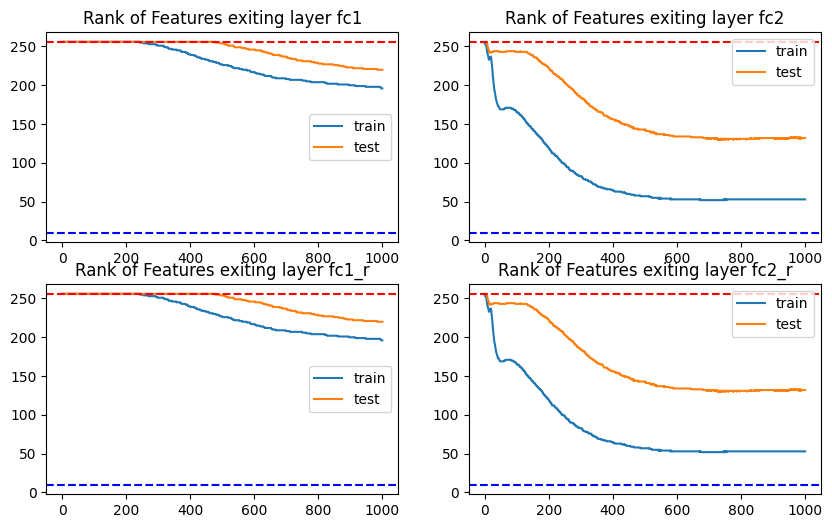

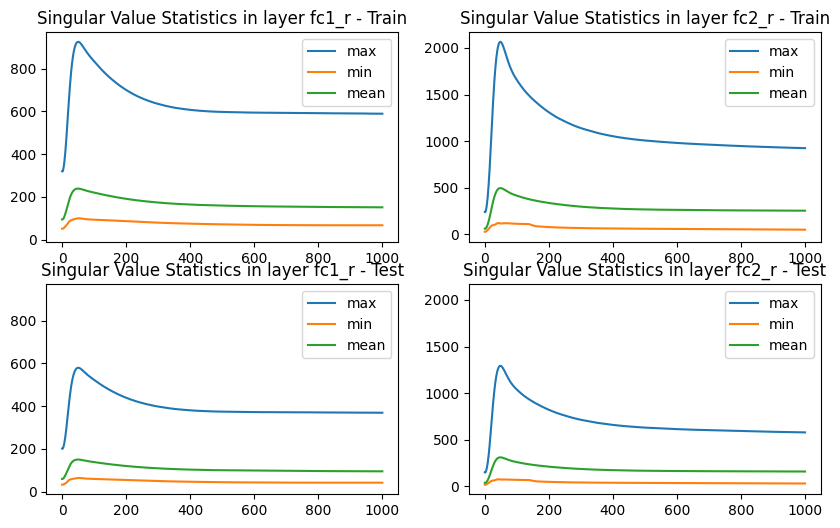

In [57]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


from os.path import join
def save_subplots(axs, root="",name="", labels=None):
    dx = 0.1
    dy = 0.1
    lbls = labels is not None
    if len(axs.shape) > 1:
        for i in range(len(axs)):
            for j in range(len(axs[i])):
             
                label_i = labels[0][i] if lbls else i
                label_j = labels[1][j] if lbls else j
                
                filename = join(root,f"{name}_{label_i}_{label_j}.png")
                extent = axs[i, j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                extent_expanded = Bbox.from_extents(extent.x0 - dx * (extent.x1 - extent.x0), extent.y0 - dy, extent.x1, extent.y1)

                axs[i, j].get_figure().savefig(filename,bbox_inches=extent_expanded)
    else:
        for i in range(len(axs)):
            label_i = labels[0][i] if lbls else i
            filename = join(root,f"{name}_{label_i}.png")
            extent = axs[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            extent_expanded = Bbox.from_extents(extent.x0 - dx * (extent.x1 - extent.x0), extent.y0 - dy, extent.x1, extent.y1)

            axs[i].get_figure().savefig(filename,bbox_inches=extent_expanded)


expected_min_rank = 10
expected_max_rank = {'fc1': 256, 'fc2': 256, 'fc1_r': 256, 'fc2_r': 256}


fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,3)
axs[0].set_title(f"Accuracy over iterations")
axs[0].plot(accuracies['orig_train'], label='train')
axs[0].plot(accuracies['orig_test'], label='test')
axs[0].legend()
axs[1].set_title(f"Loss over iterations")
axs[1].plot(losses['orig_train'], label='train')
axs[1].plot(losses['orig_test'], label='test')
axs[1].legend()
axs[2].set_title(f"Difference in rank train/test in layers")
axs[2].plot(new_data["split_diff_fc1"], label='fc1')
axs[2].plot(new_data["split_diff_fc2"], label='fc2')
axs[2].legend()
save_subplots(axs, root="imgs", name="mnist_10_accs")

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,6)

for i, (k,v) in enumerate(ranks['train'].items()):
    axs[i//2, i%2].set_title(f"Rank of Features exiting layer {k}")
    axs[i//2, i%2].plot(ranks['train'][k], label='train')
    axs[i//2, i%2].plot(ranks['test'][k], label='test')
    axs[i//2, i%2].axhline(y=expected_max_rank[k], color='red', linestyle='--')
    axs[i//2, i%2].axhline(y=expected_min_rank, color='blue', linestyle='--')
    axs[i//2, i%2].legend()

save_subplots(axs, root="imgs", name="mnist_10_ranks")
fig, axs = plt.subplots(2,2, sharey='col')
fig.set_size_inches(10,6)

for i, split in enumerate(['train','test']):
    for j, (k,v) in enumerate(new_vals[split].items()):
        axs[i, j].set_title(f"Singular Value Statistics in layer {k} - {split.capitalize()}")
        axs[i, j].plot(new_vals[split][k]['max'], label='max')
        axs[i, j].plot(new_vals[split][k]['min'], label='min')
        axs[i, j].plot(new_vals[split][k]['mean'], label='mean')
        axs[i, j].legend()

save_subplots(axs, root="imgs", name="mnist_10_sv", labels=[['train','test'],['fc1','fc2']])